<a href="https://colab.research.google.com/github/Cksdud123/colab/blob/main/Anomaly2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import cv2
import numpy as np
from PIL import Image
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet101
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
import random
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.layers import Input,Flatten,Reshape,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.regularizers import l1
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error

In [11]:
# 정상 데이터
train_dir = glob.glob('/content/drive/MyDrive/Colab Notebooks/bottle/train/good/*')
# 이상 데이터들
test_dir = glob.glob('/content/drive/MyDrive/Colab Notebooks/bottle/test/broken_large/*')
test_dir_broken_small = glob.glob('/content/drive/MyDrive/Colab Notebooks/bottle/test/broken_small/*')
test_dir_contamination = glob.glob('/content/drive/MyDrive/Colab Notebooks/bottle/test/contamination/*')

# 정상 테스트 데이터
test_dir_good = glob.glob('/content/drive/MyDrive/Colab Notebooks/bottle/test/good/*')

In [12]:
train_images = []
test_images = []
target_size = (224, 224)

In [13]:
for img_path in train_dir:
    img = Image.open(img_path)
    rgb_img = img.convert('RGB')
    resized_img = rgb_img.resize(target_size)
    img_array = np.array(resized_img)
    min_value = img_array.min()
    max_value = img_array.max()
    normalized_img_array = (img_array - min_value) / (max_value - min_value)
    train_images.append(normalized_img_array)

for img_path in test_dir + test_dir_broken_small + test_dir_contamination:
    img = Image.open(img_path)
    rgb_img = img.convert('RGB')
    resized_img = rgb_img.resize(target_size)
    img_array = np.array(resized_img)  # 수정: img_array 대신 resized_img를 사용
    min_value = img_array.min()
    max_value = img_array.max()
    normalized_img_array = (img_array - min_value) / (max_value - min_value)
    test_images.append(normalized_img_array)

In [14]:
# 데이터 준비
train_images = np.array(train_images)
test_images = np.array(test_images)

In [15]:
# 랜덤 시드 설정
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [16]:
X_train,X_test = train_test_split(train_images, test_size=0.2, random_state=42)
X_train.shape

(167, 224, 224, 3)

In [17]:
# 인코더 모델 정의
input_layer = Input(shape=(224, 224, 3))  # 이미지의 크기와 채널 수 (224x224x3)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# 디코더 모델 정의
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, decoded)

In [18]:
nb_epoch = 20
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

Epoch 1/20
6/6 [==============================] - 22s 3s/step - loss: 0.1660 - accuracy: 0.1924 - val_loss: 0.1621 - val_accuracy: 0.1803
Epoch 2/20
6/6 [==============================] - 17s 3s/step - loss: 0.1568 - accuracy: 0.3116 - val_loss: 0.1412 - val_accuracy: 0.4436
Epoch 3/20
6/6 [==============================] - 17s 3s/step - loss: 0.1266 - accuracy: 0.4044 - val_loss: 0.0986 - val_accuracy: 0.3172
Epoch 4/20
6/6 [==============================] - 19s 3s/step - loss: 0.0857 - accuracy: 0.2394 - val_loss: 0.0600 - val_accuracy: 0.1178
Epoch 5/20
6/6 [==============================] - 18s 3s/step - loss: 0.0469 - accuracy: 0.1188 - val_loss: 0.0269 - val_accuracy: 0.1160
Epoch 6/20
6/6 [==============================] - 17s 3s/step - loss: 0.0203 - accuracy: 0.1165 - val_loss: 0.0130 - val_accuracy: 0.0949
Epoch 7/20
6/6 [==============================] - 19s 3s/step - loss: 0.0119 - accuracy: 0.0960 - val_loss: 0.0114 - val_accuracy: 0.1131
Epoch 8/20
6/6 [==================

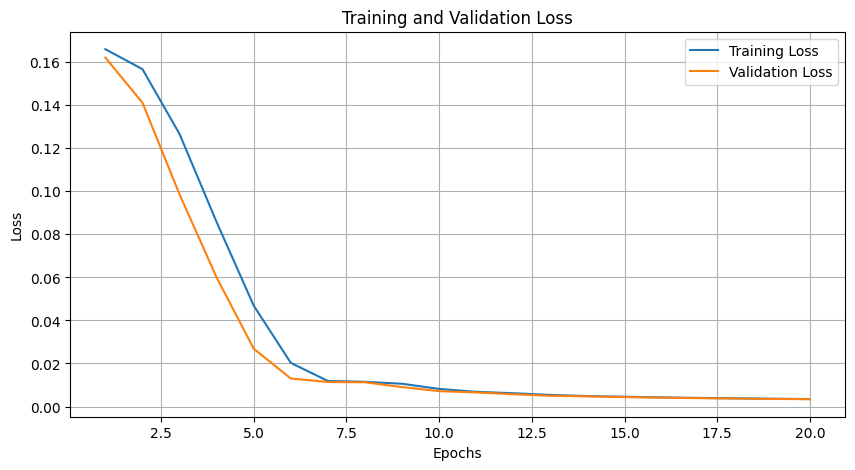

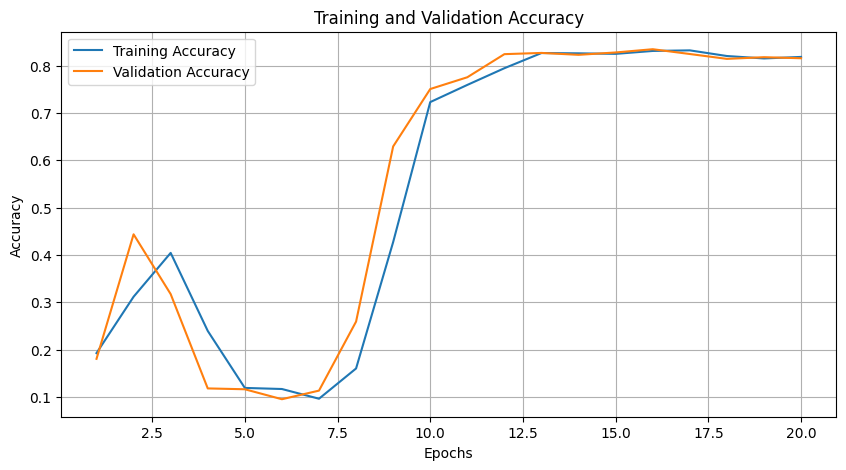

In [19]:
# 학습 결과를 기록한 history 객체에서 Loss와 Accuracy 추출
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Epoch 수
epochs = range(1, len(loss) + 1)

# Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy 그래프
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

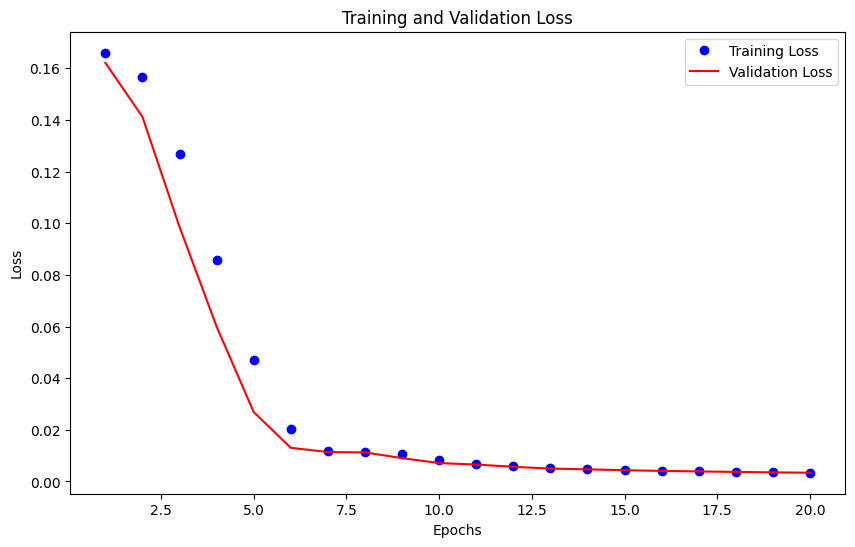

In [20]:
# 손실 함수 값 추출
loss = history['loss']
val_loss = history['val_loss']

# 그래프 그리기
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
def compare_images(image1, image2):
    # 이미지를 그레이스케일로 변환
    gray_image1 = np.mean(image1, axis=2)
    gray_image2 = np.mean(image2, axis=2)

    # 이미지 비교
    (score, _) = ssim(gray_image1, gray_image2, full=True)
    return score

# 두 개의 이미지 비교
def classify_images(image1, image2):
    similarity_score = compare_images(image1, image2)
    return similarity_score

6/6 [==============================] - 4s 638ms/step


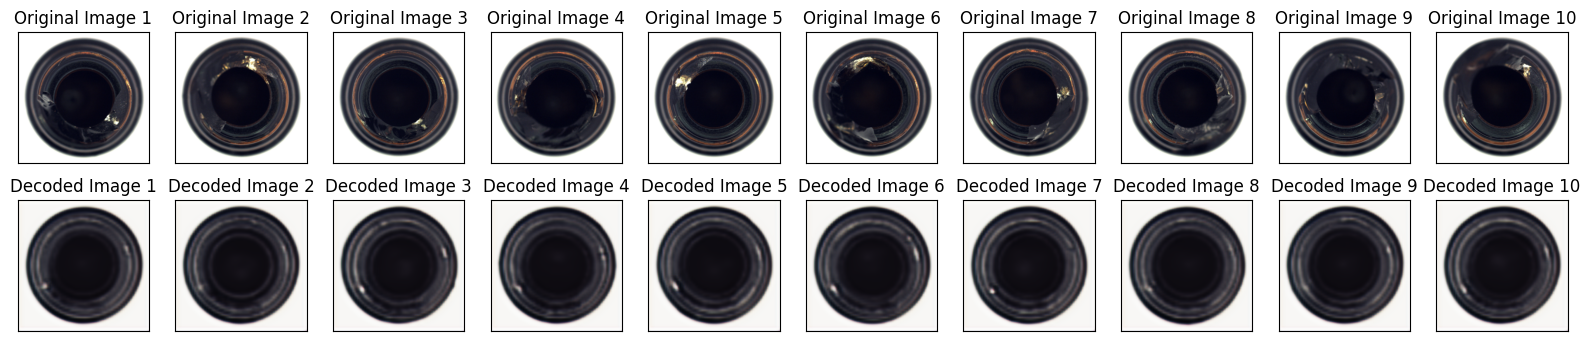

In [22]:
# test_images 모델에 입력하여 재구성 이미지 생성
decoded_test_imgs = autoencoder.predict(X_train)

# 이미지 개수 설정
n = 10  # 시각화할 이미지 개수

# 원본 이미지와 재구성 이미지 비교 그래프
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 이미지
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(224, 224, 3))
    plt.title(f'Original Image {i+1}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성 이미지
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test_imgs[i].reshape(224, 224, 3))
    plt.title(f'Decoded Image {i+1}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [23]:
# 전체 train_images와 test_images 비교하여 일치율 리스트 생성
similarity_list = []
for image1 in test_images:
    similarity_scores = [classify_images(image1, image2) for image2 in decoded_test_imgs]
    similarity_list.append(similarity_scores)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [25]:
# 각 이미지의 일치율 평균 계산
average_similarity_list = [np.mean(scores) for scores in similarity_list]

# 각 이미지의 일치율 평균 출력
for i, average_similarity in enumerate(average_similarity_list):
    print(f"Train Image {i+1}: 평균 일치율 = {average_similarity:.4f}")

Train Image 1: 평균 일치율 = 0.8027
Train Image 2: 평균 일치율 = 0.7946
Train Image 3: 평균 일치율 = 0.8134
Train Image 4: 평균 일치율 = 0.7733
Train Image 5: 평균 일치율 = 0.8006
Train Image 6: 평균 일치율 = 0.7910
Train Image 7: 평균 일치율 = 0.7708
Train Image 8: 평균 일치율 = 0.8027
Train Image 9: 평균 일치율 = 0.7828
Train Image 10: 평균 일치율 = 0.7775
Train Image 11: 평균 일치율 = 0.7414
Train Image 12: 평균 일치율 = 0.8038
Train Image 13: 평균 일치율 = 0.7851
Train Image 14: 평균 일치율 = 0.7658
Train Image 15: 평균 일치율 = 0.7660
Train Image 16: 평균 일치율 = 0.8051
Train Image 17: 평균 일치율 = 0.7872
Train Image 18: 평균 일치율 = 0.7751
Train Image 19: 평균 일치율 = 0.7903
Train Image 20: 평균 일치율 = 0.7511
Train Image 21: 평균 일치율 = 0.8153
Train Image 22: 평균 일치율 = 0.7621
Train Image 23: 평균 일치율 = 0.8083
Train Image 24: 평균 일치율 = 0.7897
Train Image 25: 평균 일치율 = 0.7903
Train Image 26: 평균 일치율 = 0.7696
Train Image 27: 평균 일치율 = 0.8171
Train Image 28: 평균 일치율 = 0.7430
Train Image 29: 평균 일치율 = 0.7691
Train Image 30: 평균 일치율 = 0.8092
Train Image 31: 평균 일치율 = 0.7615
Train Image 32: 평